# Analysis of ShuffleBench Experiment Results

The following cells import required packages and define some configurations and helper functions.

In [1]:
import os
import re
import pandas as pd
from functools import reduce
from sklearn.linear_model import LinearRegression

In [2]:
warmup_sec = 180

In [3]:
def calc_throughputs(confs, warmup_sec, load_value='\d+'):
    throughputs = {}
    for sut, (dir, *selector) in confs.items():
        id = selector[0]
        load_value = selector[1] if len(selector) == 2 else '\d+'
        pattern = re.compile(f"exp{id}_{load_value}_\d+_generic_throughput_\d+.csv")
        files = [filename for filename in os.listdir(dir) if pattern.match(filename)]
        repetitions = []
        for file in files:    
            throughput = pd.read_csv(os.path.join(dir, file), skipinitialspace=True)
            throughput['sec_start'] = throughput.loc[0:, 'timestamp'] - throughput.iloc[0]['timestamp']
            throughput = throughput.loc[throughput['sec_start'] >= warmup_sec]
            repetitions.append(throughput)
        throughputs[sut] = repetitions
    return throughputs

def calc_latencies(confs, warmup_sec):
    throughputs = {}
    for sut, (dir, id) in confs.items():
        pattern = re.compile(f"exp{id}_\d+_\d+_generic_latency_p95_total_\d+.csv")
        files = [filename for filename in os.listdir(dir) if pattern.match(filename)]
        repetitions = []
        for file in files:
            throughput = pd.read_csv(os.path.join(dir, file), skipinitialspace=True)
            throughput['sec_start'] = throughput.loc[0:, 'timestamp'] - throughput.iloc[0]['timestamp']
            throughput = throughput.loc[throughput['sec_start'] >= warmup_sec]
            repetitions.append(throughput)
        throughputs[sut] = repetitions
    return throughputs

def calc_latency_percentiles(confs, warmup_sec):
    throughputs = {}
    data = []
    for sut, (dir, id) in confs.items():
        pattern = re.compile(f"exp{id}_\d+_\d+_generic_latency_p\d+_total_\d+.csv")
        files = [filename for filename in os.listdir(dir) if pattern.match(filename)]
        percentiles = {}
        for file in files:
            percentile, repetition = re.findall(r'exp\d+_\d+_\d+_generic_latency_p(\d+)_total_(\d+).csv', file)[0]
            throughput = pd.read_csv(os.path.join(dir, file), skipinitialspace=True)
            throughput['sec_start'] = throughput.loc[0:, 'timestamp'] - throughput.iloc[0]['timestamp']
            throughput = throughput.loc[throughput['sec_start'] >= warmup_sec]
            percentiles.setdefault(percentile, []).append(throughput)
            data.append(
                {
                    'sut': sut,
                    'percentile': int(percentile),
                    'repetition': int(repetition),
                    'latency': throughput['value'].iloc[-1]
                }
            )
        throughputs[sut] = percentiles
    return pd.DataFrame(data)

def calc_lags(confs, warmup_sec):
    data = []
    for sut, (dir, id, local_max, interval) in confs.items():
        pattern = re.compile(f"exp{id}_\d+_\d+_lag-trend_lag trend_\d+.csv")
        files = [filename for filename in os.listdir(dir) if pattern.match(filename)]
        for file in files:
            load_value, repetition = re.findall(r'exp\d+_(\d+)_\d+_lag-trend_lag trend_(\d+).csv', file)[0]
            load = int(load_value) * 4
            lag = pd.read_csv(os.path.join(dir, file), skipinitialspace=True)
            lag['sec_start'] = lag.loc[0:, 'timestamp'] - lag.iloc[0]['timestamp']
            lag = lag.loc[lag['sec_start'] >= warmup_sec]
            lag['max'] = lag.value[(lag.value.shift(1) < lag.value) & (lag.value.shift(-1) < lag.value)]
            if local_max:
                lag = lag[lag['max'].notnull()]

            X = lag.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array
            Y = lag.iloc[:, 2].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column

            linear_regressor = LinearRegression()  # create object for the class
            linear_regressor.fit(X, Y)  # perform linear regression
            Y_pred = linear_regressor.predict(X)  # make predictions
            trend_slope = linear_regressor.coef_[0][0]

            data.append(
                {
                    'sut': sut,
                    'load_value': load,
                    'interval': interval-1,
                    'repetition': int(repetition),
                    'trend_slope': trend_slope,
                    #'suitable': trend_slope <= load * 0.01
                }
            )
    return pd.DataFrame(data)

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import numpy as np

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [5, (5/3)*2]
plt.rcParams['pdf.fonttype'] = 42 # TrueType fonts
plt.rcParams['ps.fonttype'] = 42 # TrueType fonts
plt.rcParams['axes.facecolor']='w'
plt.rcParams['axes.edgecolor']='555555'
#plt.rcParams['ytick.color']='black'
plt.rcParams['grid.color']='dddddd'
plt.rcParams['axes.spines.top']='false'
plt.rcParams['axes.spines.right']='false'
plt.rcParams['legend.frameon']='true'
plt.rcParams['legend.framealpha']='1'
plt.rcParams['legend.edgecolor']='1'
plt.rcParams['legend.borderpad']='1'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[colors[0], colors[2], colors[5], colors[1], colors[3], colors[4], colors[6]]) 

@FuncFormatter
def load_formatter(x, pos):
    return f'{(x/1000):.0f}k' if x != 0 else f'{x:.0f}'

@FuncFormatter
def byte_formatter(x, pos):
    return f'{(x):.0f}'+u"\u202FB" if x != 0 else f'{x:.0f}'

@FuncFormatter
def mb_formatter(x, pos):
    return f'{(x/1000/1000):.0f}'+u"\u202FMB" if x != 0 else f'{x:.0f}'

@FuncFormatter
def ms_formatter(x, pos):
    return f'{(x*1000):.0f}'

@FuncFormatter
def p_formatter(x, pos):
    return f'p{x:.0f}'

def make_throughput_barplot(throughputs):
    #data = [[9, 20, 20, 30, 30, 10, 40, 50, 100], [11, 20, 21, 22, 23, 29, 31], [10, 21, 24, 21, 30, 32]]
    all_means = [np.array([df["value"].mean() for df in dfs]) for k, dfs in throughputs.items()]
    median_of_means = [np.median(means) for means in all_means]
    yerr_upper_of_means = [np.max(means) - np.median(means) for means in all_means]
    yerr_lower_of_means = [np.median(means) - np.min(means) for means in all_means]
    x_pos = np.arange(len(throughputs.keys()))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    trans_colors = [mcolors.to_rgba(color, alpha=0.2) for color in colors]
    bplot = plt.bar(x_pos, median_of_means, color=trans_colors, yerr=[yerr_upper_of_means, yerr_lower_of_means], capsize=5, linewidth=1.0, edgecolor=colors, ecolor='#555555', error_kw={'elinewidth': 1.0, 'capthick': 1.0})
    plt.xticks(list(range(0, len(throughputs))), throughputs.keys())
    plt.xlabel("stream processing framework")
    plt.ylabel("records/second") # processed records/second
    plt.ylim(ymin=0)

    ax = plt.gca()
    ax.set_xticklabels(throughputs.keys())
    ax.yaxis.set_major_formatter(FuncFormatter(load_formatter))
    return ax

def make_throughput_barplot_multi(throughputs, suts):
    grouped_confs = {}
    for sut, config in suts:
        sut, category, *_ = sut.split('/') + ['default', 'palceholder']
        grouped_confs.setdefault(category,[]).append(sut)
    labels = next(iter(grouped_confs.values()))
    categories = grouped_confs.keys()
    x_pos = np.arange(len(labels))
    width = 0.8/len(categories)
    space = 0.05
    ax = plt.gca()
    color_offset = 4
    all_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for offset, (category, suts) in enumerate(grouped_confs.items()):
        all_means = [np.array([df["value"].mean() for df in dfs]) for k, dfs in throughputs.items() if k.split('/')[1] == category]
        median_of_means = [np.median(means) for means in all_means]
        yerr_upper_of_means = [np.max(means) - np.median(means) for means in all_means]
        yerr_lower_of_means = [np.median(means) - np.min(means) for means in all_means]
        color = all_colors[(color_offset + offset) % len(all_colors)]
        trans_color = mcolors.to_rgba(color, alpha=0.2)
        plt.bar(x_pos+(offset*width), median_of_means, width=width, label=category, color=trans_color, yerr=[yerr_upper_of_means, yerr_lower_of_means], capsize=5, linewidth=1.0, edgecolor=color, ecolor='#555555', error_kw={'elinewidth': 1.0, 'capthick': 1.0})

    plt.xticks(x_pos+((width/2)*(len(categories)-1)), labels)
    plt.xlabel("stream processing framework")
    plt.ylabel("records/second") # processed records/second
    plt.ylim(ymin=0)
    plt.legend(
            handlelength=0.75,
            borderpad=0.25,
            ncol=len(categories),
            columnspacing=1,
            loc='upper center',
            bbox_to_anchor=(0.5, 1.1))

    ax.yaxis.set_major_formatter(FuncFormatter(load_formatter))
    return ax

def make_sustainable_throughput_barplotsXXX(throughputs):
    #data = [[9, 20, 20, 30, 30, 10, 40, 50, 100], [11, 20, 21, 22, 23, 29, 31], [10, 21, 24, 21, 30, 32]]
    all_means = [np.array([df["value"].mean() for df in dfs]) for k, dfs in throughputs.items()]
    median_of_means = [np.median(means) for means in all_means]
    yerr_upper_of_means = [np.max(means) - np.median(means) for means in all_means]
    yerr_lower_of_means = [np.median(means) - np.min(means) for means in all_means]
    x_pos = np.arange(len(throughputs.keys()))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    trans_colors = [mcolors.to_rgba(color, alpha=0.2) for color in colors]
    bplot = plt.bar(x_pos, median_of_means, color=trans_colors, linewidth=1.0, edgecolor=colors, ecolor='#555555', error_kw={'elinewidth': 1.0, 'capthick': 1.0})
    plt.xticks(list(range(0, len(throughputs))), throughputs.keys())
    plt.xlabel("stream processing framework")
    plt.ylabel("records/second") # processed records/second
    plt.ylim(ymin=0)

    ax = plt.gca()
    ax.set_xticklabels(throughputs.keys())
    ax.yaxis.set_major_formatter(FuncFormatter(load_formatter))
    return ax

def make_latency_barplot(latencies):
    all_totals = [np.array([df["value"].iloc[-1] for df in dfs]) for k, dfs in latencies.items()]
    median_of_totals = [np.median(totals) for totals in all_totals]
    yerr_upper_of_means = [np.max(totals) - np.median(totals) for totals in all_totals]
    yerr_lower_of_means = [np.median(totals) - np.min(totals) for totals in all_totals]
    x_pos = np.arange(len(latencies.keys()))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    trans_colors = [mcolors.to_rgba(color, alpha=0.2) for color in colors]
    bplot = plt.bar(x_pos, median_of_totals, color=trans_colors, yerr=[yerr_upper_of_means, yerr_lower_of_means], capsize=5, linewidth=1.0, edgecolor=colors, ecolor='#555555', error_kw={'elinewidth': 1.0, 'capthick': 1.0})
    plt.xticks(list(range(0, len(latencies))), latencies.keys())
    plt.xlabel("stream processing framework")
    plt.ylabel("milliseconds")
    plt.ylim(ymin=0, ymax=0.21)

    ax = plt.gca()
    ax.set_xticklabels(latencies.keys())
    ax.yaxis.set_major_formatter(FuncFormatter(ms_formatter))
    return ax

def make_latency_barplot_multi(latencies, suts):
    grouped_confs = {}
    for sut, config in suts:
        sut, category, *_ = sut.split('/') + ['default', 'palceholder']
        grouped_confs.setdefault(category,[]).append(sut)
    labels = next(iter(grouped_confs.values()))
    categories = grouped_confs.keys()
    x_pos = np.arange(len(labels))
    width = 0.8/len(categories)
    space = 0.05
    ax = plt.gca()
    color_offset = 4
    all_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for offset, (category, suts) in enumerate(grouped_confs.items()):
        all_totals = [np.array([df["value"].iloc[-1] for df in dfs]) for k, dfs in latencies.items() if k.split('/')[1] == category]
        median_of_means = [np.median(means) for means in all_totals]
        yerr_upper_of_means = [np.max(means) - np.median(means) for means in all_totals]
        yerr_lower_of_means = [np.median(means) - np.min(means) for means in all_totals]
        color = all_colors[(color_offset + offset) % len(all_colors)]
        trans_color = mcolors.to_rgba(color, alpha=0.2)
        plt.bar(x_pos+(offset*width), median_of_means, width=width, label=category, color=trans_color, yerr=[yerr_upper_of_means, yerr_lower_of_means], capsize=5, linewidth=1.0, edgecolor=color, ecolor='#555555', error_kw={'elinewidth': 1.0, 'capthick': 1.0})

    plt.xticks(x_pos+((width/2)*(len(categories)-1)), labels)
    plt.xlabel("stream processing framework")
    plt.ylabel("milliseconds")
    plt.ylim(ymin=0, ymax=0.21)
    plt.legend(
            handlelength=0.75,
            borderpad=0.25,
            ncol=len(categories),
            columnspacing=1,
            loc='upper center',
            bbox_to_anchor=(0.5, 1.1))

    ax.yaxis.set_major_formatter(FuncFormatter(ms_formatter))
    return ax

def make_latency_quantileplots(percentiles):
    plt.figure()
    percentiles = percentiles.groupby(['sut', 'percentile']).agg('median').reset_index()
    percentiles = percentiles.pivot(index='percentile', columns='sut', values='latency')
    ax = percentiles.plot(kind='line', linewidth=1.0)
    plt.legend(
        handlelength=0.75,
        borderpad=0.25,
        ncol=len(percentiles.columns),
        columnspacing=1,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.1))
    #ax = df.plot(kind='line',x='dim_value', legend=False, use_index=True)
    ax.set_xlabel('percentile') # processed records/second
    ax.set_ylabel('milliseconds')
    ax.set_ylim(ymin=0, ymax=0.31)
    ax.set_xlim(xmin=0)
    #ax.set_xlim(xmax=910)
    #ax.xaxis.set_ticks(np.arange(0, 910, 180))
    ax.yaxis.set_major_formatter(FuncFormatter(ms_formatter))
    ax.xaxis.set_major_formatter(FuncFormatter(p_formatter))
    return ax


### Baseline Evaluation of Throughput

The baseline evaluation deploys each framework with 9 application instances, where each instance is assigned 4 GB of memory and a single virtual CPU core, resulting in a total parallelism of 9. The number of real-time consumers is set to one million, the total selectivity to 20 %, and generated records have a size of 1024 byte.

#### Ad-hoc Throughput (Flink, Hazelcast, Kafka Streams)

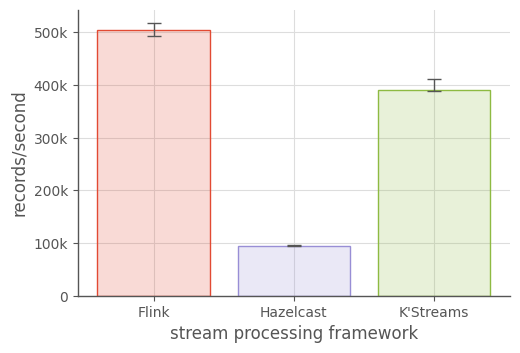

In [5]:
confs_baseline_atp = {
    "Flink": ("../results", 19),
    "Hazelcast": ("../results", 23),
    "K'Streams": ("../results", 27),
}
make_throughput_barplot(calc_throughputs(confs_baseline_atp, warmup_sec))
plt.tight_layout(pad=0.0)
plt.savefig('plots/barplot_baseline_atp.pdf')

#### Ad-hoc Throughput (Spark)

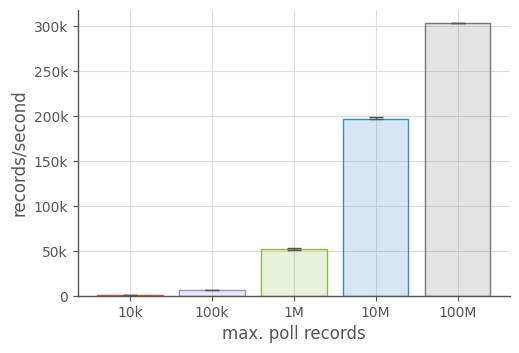

In [6]:
confs_baseline_spark_atp = {
    "10k": ("../results", 48, 10000),
    "100k": ("../results", 48, 100000),
    "1M": ("../results", 48, 1000000),
    "10M": ("../results", 48, 10000000),
    "100M": ("../results", 48, 100000000),
}
ax = make_throughput_barplot(calc_throughputs(confs_baseline_spark_atp, warmup_sec))
ax.set_xlabel("max. poll records")
plt.tight_layout(pad=0.0)
plt.savefig('plots/barplot_baseline_atp_spark.pdf')

#### Sustainable Throughput

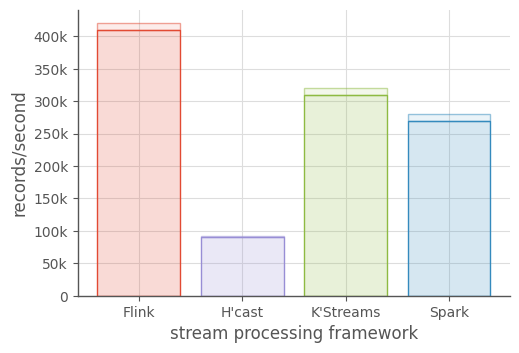

In [7]:
confs_baseline_stp = {
    # Framework : (directory, exp_id, use local max. for trend, interval)
    "Flink": ("../results", 122, False, 2500*4),
    "H'cast": ("../results", 150, False, 500*4),
    "K'Streams": ("../results", 157, False, 2500*4),
    "Spark": ("../results", 128, True, 2500*4),
}

lags = calc_lags(confs_baseline_stp, warmup_sec)
# Take the median of each SUT and load
lags = lags.groupby(['sut','load_value', 'interval'])["trend_slope"].median().reset_index()
lags['suitable'] = lags['trend_slope'] <= lags['load_value'] * 0.01
lags = lags.sort_values(['sut', 'load_value'])
lags['max_suitable'] = lags.groupby('sut')['suitable'].cummin()
suitable = lags[lags['max_suitable'] == True]
max_suitable = suitable.loc[suitable.groupby(['sut'])["load_value"].idxmax()]
suts = max_suitable['sut'].tolist()
load_values = max_suitable['load_value'].tolist()
intervals = max_suitable['interval'].tolist()
x_pos = np.arange(len(suts))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors_alpha02 = [mcolors.to_rgba(color, alpha=0.2) for color in colors]
colors_alpha05 = [mcolors.to_rgba(color, alpha=0.5) for color in colors]
colors_alpha01 = [mcolors.to_rgba(color, alpha=0.1) for color in colors]
bplot = plt.bar(x_pos, load_values, color=colors_alpha02, linewidth=1.0, edgecolor=colors)
bplot = plt.bar(x_pos, intervals, bottom=load_values, color=colors_alpha01, linewidth=1.0, edgecolor=colors_alpha05)
plt.xticks(list(range(0, len(suts))), suts)
plt.xlabel("stream processing framework")
plt.ylabel("records/second") # processed records/second
plt.ylim(ymin=0)
ax = plt.gca()
ax.set_xticklabels(suts)
#ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_formatter(FuncFormatter(load_formatter))

plt.tight_layout(pad=0.0)
plt.savefig('plots/barplot_baseline_stp.pdf')

#### Latency

Flink's median p95-latency: 0.0881840551618703s
Kafka Streams's median p95-latency: 0.1835142181043369s
Hazelcast's median p95-latency: 0.0079088142464565s


<Figure size 500x333.333 with 0 Axes>

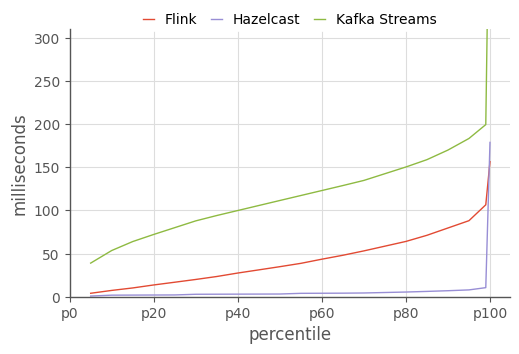

In [8]:
confs_baseline_lty = {
    "Flink": ("../results", 55),
    "Hazelcast": ("../results", 61),
    "Kafka Streams": ("../results", 66),
    #"Spark": ("../results", 96),
}

percentiles = calc_latency_percentiles(confs_baseline_lty, 0)
ax = make_latency_quantileplots(percentiles)
plt.tight_layout(pad=0.0)
plt.savefig('plots/quantileplot_baseline_lty.pdf')

print(f"Flink's median p95-latency: {percentiles[(percentiles['sut'] == 'Flink') & (percentiles['percentile'] == 95)]['latency'].median()}s")
print(f"Kafka Streams's median p95-latency: {percentiles[(percentiles['sut'] == 'Kafka Streams') & (percentiles['percentile'] == 95)]['latency'].median()}s")
print(f"Hazelcast's median p95-latency: {percentiles[(percentiles['sut'] == 'Hazelcast') & (percentiles['percentile'] == 95)]['latency'].median()}s")


Spark median latency: 10.0 s


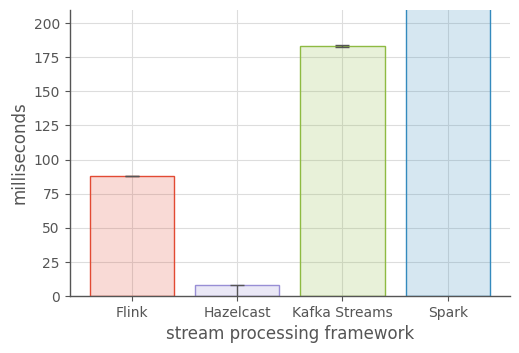

In [9]:
confs_baseline_ltc = {
    "Flink": ("../results", 55),
    "Hazelcast": ("../results", 61),
    "Kafka Streams": ("../results", 66),
    "Spark": ("../results", 96),
}

latencies = calc_latencies(confs_baseline_ltc, 0)
make_latency_barplot(latencies)
plt.tight_layout(pad=0.0)
plt.savefig('plots/barplot_baseline_lty.pdf', pad_inches=-1.0)
print(f"Spark median latency: {np.median(np.array([df['value'].iloc[-1] for df in latencies['Spark']]))} s")

### Evaluation of Deployment Impact

We compare our baseline evaluation with 9 single-CPU instances to a deployment with 3 3-CPU instances.

#### Ad-hoc Throughput

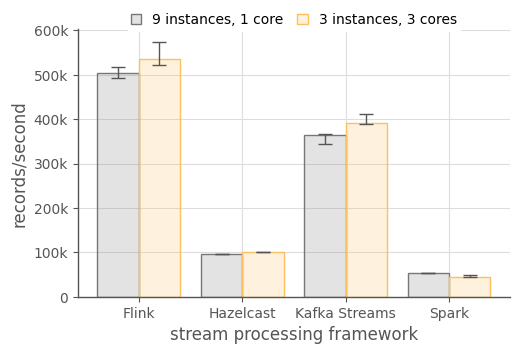

In [10]:
confs_multicore_atp = {
    "Flink/9 instances, 1 core": ("../results", 19),
    "Flink/3 instances, 3 cores": ("../results", 17),
    "Hazelcast/9 instances, 1 core": ("../results", 23),
    "Hazelcast/3 instances, 3 cores": ("../results", 22),
    "Kafka Streams/9 instances, 1 core": ("../results", 28),
    "Kafka Streams/3 instances, 3 cores": ("../results", 27),
    "Spark/9 instances, 1 core": ("../results", 53, 1000000),
    "Spark/3 instances, 3 cores": ("../results", 167),
}
throughputs = calc_throughputs(confs_multicore_atp, warmup_sec)
make_throughput_barplot_multi(throughputs,confs_multicore_atp.items())

plt.tight_layout(pad=0.0)
plt.savefig('plots/barplot_multicore_atp.pdf')

#### Latency

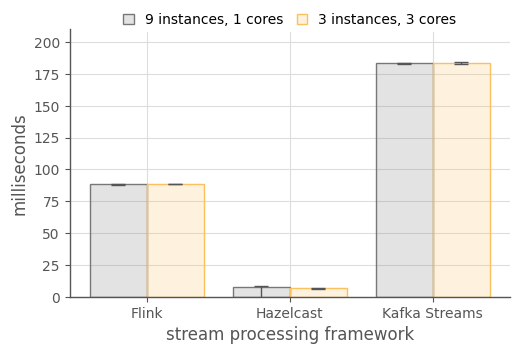

In [11]:
confs_multicore_ltc = {
    "Flink/9 instances, 1 cores": ("../results", 55),
    "Flink/3 instances, 3 cores": ("../results", 30),
    "Hazelcast/9 instances, 1 cores": ("../results", 61),
    "Hazelcast/3 instances, 3 cores": ("../results", 33),
    "Kafka Streams/9 instances, 1 cores": ("../results", 66),
    "Kafka Streams/3 instances, 3 cores": ("../results", 36)
}

latencies = calc_latencies(confs_multicore_ltc, 0)
make_latency_barplot_multi(latencies, confs_multicore_ltc.items())
plt.tight_layout(pad=0.0)
plt.savefig('plots/barplot_multicore_lty.pdf')

### Evaluation of Record Size Impact

The compare the record size of the baseline evaluation (1024 bytes) with record sizes of 128, 256, and 512 bytes.

#### Ad-hoc Throughput

With 1024 byte records, Flink achieves 529% throughput of Hazelcast.
With 1024 byte records, Kafka Streams achieves 382% throughput of Hazelcast.
With 128 byte records, Flink achieves 146% throughput of Hazelcast.
With 128 byte records, Hazelcast achieves 68% throughput of Flink.
With 128 byte records, Kafka Streams achieves 100% throughput of Hazelcast.


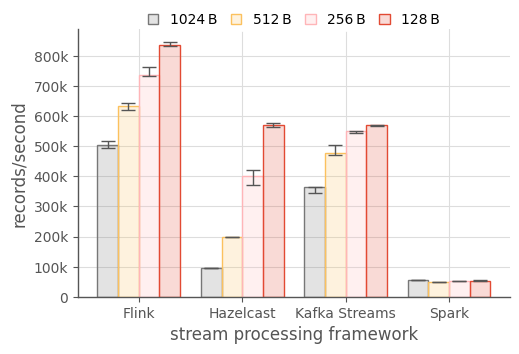

In [12]:
b=u"\u202FB" # Unicode narrow non-breaking space
confs_recordsize_atp = {
    "Flink/1024"+b: ("../results", 19),
    "Flink/512"+b: ("../results", 58),
    "Flink/256"+b: ("../results", 40),
    "Flink/128"+b: ("../results", 18),
    "Hazelcast/1024"+b: ("../results", 23),
    "Hazelcast/512"+b: ("../results", 60),
    "Hazelcast/256"+b: ("../results", 41),
    "Hazelcast/128"+b: ("../results", 21),
    "Kafka Streams/1024"+b: ("../results", 28),
    "Kafka Streams/512"+b: ("../results", 65),
    "Kafka Streams/256"+b: ("../results", 42),
    "Kafka Streams/128"+b: ("../results", 26),
    "Spark/1024"+b: ("../results", 53, 1000000),
    "Spark/512"+b: ("../results", 141),
    "Spark/256"+b: ("../results", 139),
    "Spark/128"+b: ("../results", 137),
}
throughputs = calc_throughputs(confs_recordsize_atp, warmup_sec)
make_throughput_barplot_multi(throughputs, confs_recordsize_atp.items())
plt.tight_layout(pad=0.0)
plt.savefig('plots/barplot_recordsize_atp.pdf')

throughput_flink_1024b = np.median(np.array([df["value"].mean() for df in throughputs['Flink/1024'+b]]))
throughput_hzcast_1024b = np.median(np.array([df["value"].mean() for df in throughputs['Hazelcast/1024'+b]]))
throughput_kstreams_1024b = np.median(np.array([df["value"].mean() for df in throughputs['Kafka Streams/1024'+b]]))
throughput_flink_128b = np.median(np.array([df["value"].mean() for df in throughputs['Flink/128'+b]]))
throughput_hzcast_128b = np.median(np.array([df["value"].mean() for df in throughputs['Hazelcast/128'+b]]))
throughput_kstreams_128b = np.median(np.array([df["value"].mean() for df in throughputs['Kafka Streams/128'+b]]))

print(f"With 1024 byte records, Flink achieves {(throughput_flink_1024b/throughput_hzcast_1024b):.0%} throughput of Hazelcast.")
print(f"With 1024 byte records, Kafka Streams achieves {(throughput_kstreams_1024b/throughput_hzcast_1024b):.0%} throughput of Hazelcast.")
print(f"With 128 byte records, Flink achieves {(throughput_flink_128b/throughput_hzcast_128b):.0%} throughput of Hazelcast.")
print(f"With 128 byte records, Hazelcast achieves {(throughput_hzcast_128b/throughput_flink_128b):.0%} throughput of Flink.")
print(f"With 128 byte records, Kafka Streams achieves {(throughput_kstreams_128b/throughput_hzcast_128b):.0%} throughput of Hazelcast.")


#### Latency

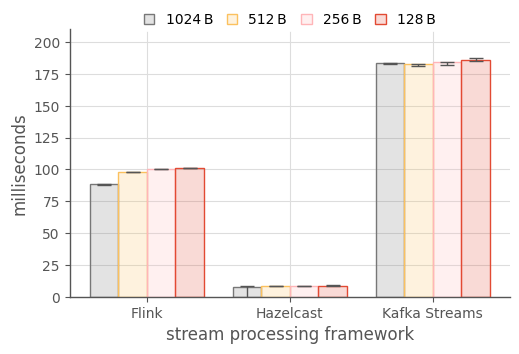

In [13]:
b=u"\u202FB" # Unicode narrow non-breaking space
confs_recordsize_lty = {
    "Flink/1024"+b: ("../results", 55),
    "Flink/512"+b: ("../results", 152),
    "Flink/256"+b: ("../results", 151),
    "Flink/128"+b: ("../results", 54),
    "Hazelcast/1024"+b: ("../results", 61),
    "Hazelcast/512"+b: ("../results", 162),
    "Hazelcast/256"+b: ("../results", 154),
    "Hazelcast/128"+b: ("../results", 153),
    "Kafka Streams/1024"+b: ("../results", 66),
    "Kafka Streams/512"+b: ("../results", 156),
    "Kafka Streams/256"+b: ("../results", 155),
    "Kafka Streams/128"+b: ("../results", 64),
}

latencies = calc_latencies(confs_recordsize_lty, 0)
make_latency_barplot_multi(latencies, confs_recordsize_lty.items())
plt.tight_layout(pad=0.0)
plt.savefig('plots/barplot_recordsize_lty.pdf')

### Evaluation of Consumer Count Impact

We compare the 1 million consumers of our baseline evaluation with 100,000 consumers.

#### Ad-hoc Throughput

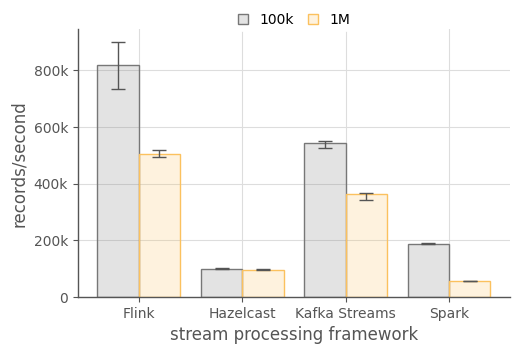

In [14]:
confs_numconsumers_atp = {
    "Flink/100k": ("../results", 31),
    "Flink/1M": ("../results", 19),
    "Hazelcast/100k": ("../results", 34),
    "Hazelcast/1M": ("../results", 23),
    "Kafka Streams/100k": ("../results", 38), # wrongly labeled
    "Kafka Streams/1M": ("../results", 28),
    "Spark/100k": ("../results", 142),
    "Spark/1M": ("../results", 53, 1000000),
}
throughputs = calc_throughputs(confs_numconsumers_atp, warmup_sec)
make_throughput_barplot_multi(throughputs, confs_numconsumers_atp.items())
plt.tight_layout(pad=0.0)
plt.savefig('plots/barplot_numconsumers_atp.pdf')

#### Latency

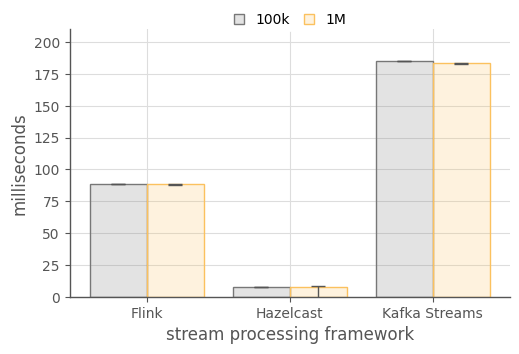

In [15]:
confs_numconsumers_lty = {
    "Flink/100k": ("../results", 56),
    "Flink/1M": ("../results", 55),
    "Hazelcast/100k": ("../results", 62),
    "Hazelcast/1M": ("../results", 61),
    "Kafka Streams/100k": ("../results", 67),
    "Kafka Streams/1M": ("../results", 66),
}

latencies = calc_latencies(confs_numconsumers_lty, 0)
make_latency_barplot_multi(latencies, confs_numconsumers_lty.items())
plt.tight_layout(pad=0.0)
plt.savefig('plots/barplot_numconsumers_lty.pdf')

### Evaluation of Selectivity Impact

We compare the 20% total selectivity of our baseline evaluation with a total selectivity of 0% and 100%.

#### Ad-hoc Throughput

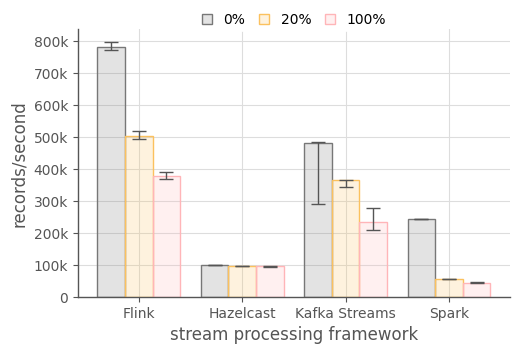

In [16]:
confs_selectivity_atp = {
    "Flink/0%": ("../results", 97),
    "Flink/20%": ("../results", 19),
    "Flink/100%": ("../results", 98),
    "Hazelcast/0%": ("../results", 100),
    "Hazelcast/20%": ("../results", 23),
    "Hazelcast/100%": ("../results", 101),
    "Kafka Streams/0%": ("../results", 103),
    "Kafka Streams/20%": ("../results", 28),
    "Kafka Streams/100%": ("../results", 104),
    "Spark/0%": ("../results", 144),
    "Spark/20%": ("../results", 53, 1000000),
    "Spark/100%": ("../results", 136),
}
throughputs = calc_throughputs(confs_selectivity_atp, warmup_sec)
make_throughput_barplot_multi(throughputs, confs_selectivity_atp.items())
plt.tight_layout(pad=0.0)
plt.savefig('plots/barplot_selectivity_atp.pdf')

#### Latency

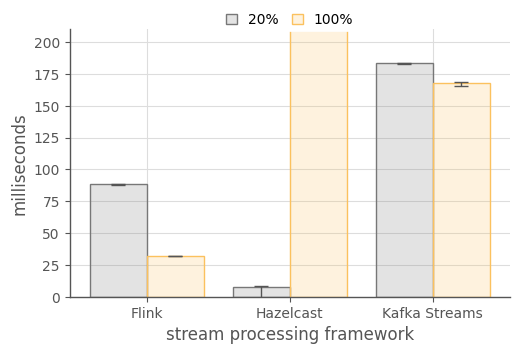

In [17]:
confs_selectivities_lty = {
    "Flink/20%": ("../results", 55),
    "Flink/100%": ("../results", 130),
    "Hazelcast/20%": ("../results", 61),
    "Hazelcast/100%": ("../results", 132), # so high because load too high
    "Kafka Streams/20%": ("../results", 66),
    "Kafka Streams/100%": ("../results", 134),
}

latencies = calc_latencies(confs_selectivities_lty, 0)
make_latency_barplot_multi(latencies, confs_selectivities_lty.items())
plt.tight_layout(pad=0.0)
plt.savefig('plots/barplot_selectivity_lty.pdf')